In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [15]:
df = pd.read_table('Data/RFP/Sequence_to_Expression.txt')
df.head()

Date    Time Media  Ec     OD600  Ex485Em535  Ex550Em650
0  2025_04_25  330_PM    M9  33  0.314510    383540.0      5355.5
1  2025_04_25  330_PM    M9  33  0.340022    388601.0      4213.5
2  2025_04_25  330_PM    M9  34  0.180372    472020.0     92525.5
3  2025_04_25  330_PM    M9  34  0.170433    467968.0     83579.5
4  2025_04_25  330_PM    M9  35  0.083273    124494.0    337765.5

In [72]:
seq_map= pd.read_table('Data/RFP/Sequences.txt')
seq_map.head()

Ec Description                                sequence
0  33  pClone_GFP    CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT
1  34       P533A    TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA
2  35          P5    TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA
3  36        OsmY  CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA
4  37   OsmY_C12A  CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA

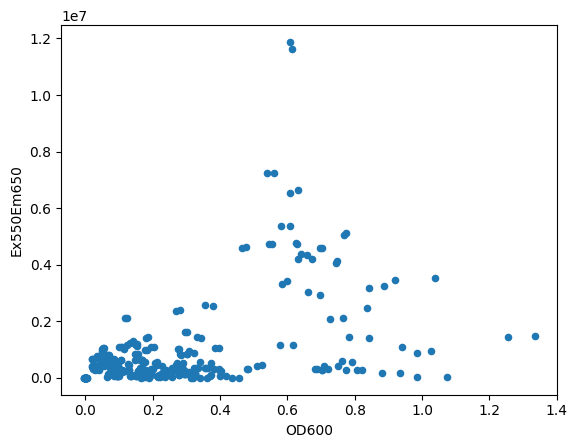

In [17]:
ax = df.plot.scatter(x='OD600', y='Ex550Em650')
plt.show()

In [73]:
df_cut = df[(df['OD600'] > 0.05) & (df['OD600'] < 0.5)]
df_cut = df_cut[df_cut['Media'] == 'M9']
df_cut.head()

Date    Time Media  Ec     OD600  Ex485Em535  Ex550Em650
0  2025_04_25  330_PM    M9  33  0.314510    383540.0      5355.5
1  2025_04_25  330_PM    M9  33  0.340022    388601.0      4213.5
2  2025_04_25  330_PM    M9  34  0.180372    472020.0     92525.5
3  2025_04_25  330_PM    M9  34  0.170433    467968.0     83579.5
4  2025_04_25  330_PM    M9  35  0.083273    124494.0    337765.5

In [74]:
for idx, row in seq_map.iterrows():
    if len(row['sequence']) > 36:
        seq_map.at[idx, 'sequence_trimmed'] = row['sequence'][:36]
    else:
        seq_map.at[idx, 'sequence_trimmed'] = row['sequence']

seq_map.head()

Ec Description                                sequence  \
0  33  pClone_GFP    CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT   
1  34       P533A    TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA   
2  35          P5    TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA   
3  36        OsmY  CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA   
4  37   OsmY_C12A  CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA   

                       sequence_trimmed  
0  CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT  
1  TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA  
2  TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA  
3  CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACA  
4  CCCGAGCGGTTTCAAAATTGTGATATATATTTAACA

In [75]:
def pad_centered(sequence):
    sequence = sequence.replace('_', '')
    desired_length = 150
    right_padding = 30
    left_padding = desired_length - right_padding - len(sequence)
    return '0' * left_padding + sequence + '0' * right_padding

def pad_pclone(sequence):
    sequence = sequence.replace('_', '')
    desired_length = 150
    downstream = 'GCGGGAAGACAACTAGGGGCCCAAGTTCAC' # 30bp downstream of the sequence
    left_padding = desired_length - len(downstream) - len(sequence)
    return '0' * left_padding + sequence + downstream


In [81]:
def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

CNN_6_1_2 = keras.saving.load_model('Models/CNN_6_1_2.keras')
CNN_6_1_4 = keras.saving.load_model('Models/CNN_6_1_4.keras')
CNN_8_0 = keras.saving.load_model('Models/CNN_8_0.keras')
CNN_8_1 = keras.saving.load_model('Models/CNN_8_1.keras')
CNN_8_2 = keras.saving.load_model('Models/CNN_8_2.keras')
CNN_8_0_hp = keras.saving.load_model('Models/CNN_8_0_hp.keras')

sequences = seq_map['sequence'].apply(lambda x: x.replace('_', '')).tolist()
sequences_trimmed = seq_map['sequence_trimmed'].apply(lambda x: x.replace('_', '')).tolist()

seq_map['CNN_6_1_2_Pred_RFP'] = CNN_6_1_2.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
seq_map['CNN_6_1_2_trim_Pred_RFP'] = CNN_6_1_2.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences_trimmed])).flatten()
seq_map['CNN_6_1_2_centered_Pred_RFP'] = CNN_6_1_2.predict(np.array([padded_one_hot_encode(pad_centered(seq)) for seq in sequences_trimmed])).flatten()
seq_map['CNN_6_1_2_pClone_Pred_RFP'] = CNN_6_1_2.predict(np.array([padded_one_hot_encode(pad_pclone(seq)) for seq in sequences_trimmed])).flatten()
seq_map['CNN_6_1_4_Pred_RFP'] = CNN_6_1_4.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
seq_map['CNN_6_1_4_centered_Pred_RFP'] = CNN_6_1_4.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences_trimmed])).flatten()
seq_map['CNN_8_0_Pred_RFP'] = CNN_8_0.predict(np.array([padded_one_hot_encode(seq.ljust(36, '0')) for seq in sequences_trimmed])).flatten()
seq_map['CNN_8_1_Pred_RFP'] = CNN_8_1.predict(np.array([padded_one_hot_encode(seq.ljust(36, '0')) for seq in sequences_trimmed])).flatten()
seq_map['CNN_8_2_Pred_RFP'] = CNN_8_2.predict(np.array([padded_one_hot_encode(seq.ljust(36, '0')) for seq in sequences_trimmed])).flatten()
seq_map['CNN_8_0_hp_Pred_RFP'] = CNN_8_0_hp.predict(np.array([padded_one_hot_encode(seq.ljust(36, '0')) for seq in sequences_trimmed])).flatten()

prediction_cols = ['CNN_6_1_2_Pred_RFP', 'CNN_6_1_2_trim_Pred_RFP', 
                   'CNN_6_1_4_Pred_RFP', 'CNN_6_1_4_centered_Pred_RFP',
                   'CNN_6_1_2_centered_Pred_RFP', 'CNN_6_1_2_pClone_Pred_RFP',
                   'CNN_8_0_Pred_RFP', 'CNN_8_1_Pred_RFP',
                   'CNN_8_2_Pred_RFP', 'CNN_8_0_hp_Pred_RFP']


c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [77]:
seq_map.head()

Ec Description                                sequence  \
0  33  pClone_GFP    CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT   
1  34       P533A    TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA   
2  35          P5    TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA   
3  36        OsmY  CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA   
4  37   OsmY_C12A  CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA   

                       sequence_trimmed  CNN_6_1_2_Pred_RFP  \
0  CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT            0.331931   
1  TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA            0.454497   
2  TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA            0.512579   
3  CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACA            0.284272   
4  CCCGAGCGGTTTCAAAATTGTGATATATATTTAACA            0.284272   

   CNN_6_1_2_trim_Pred_RFP  CNN_6_1_2_centered_Pred_RFP  \
0                 0.331931                     0.260405   
1                 0.454497                     0.399925   
2                 0.512579                     0.415752   
3                 0.308339                     0.465356   
4                 0.308339                     0.499839   

   CNN_6_1_2_pClone_Pred_RFP  CNN_6_1_4_Pred_RFP  CNN_6_1_4_centered_Pred_RFP  \
0                   0.250731            0.264701                     0.264701   
1                   0.408258            0.361850                     0.361850   
2                   0.414276            0.292931                     0.292931   
3                   0.437885            0.286110                     0.272036   
4                   0.487552            0.299390                     0.277685   

   CNN_8_0_Pred_RFP  CNN_8_1_Pred_RFP  CNN_8_2_Pred_RFP  CNN_8_0_hp_Pred_RFP  
0          0.250633          0.280258          0.288958             0.281676  
1          0.220051          0.268423          0.287431             0.299158  
2          0.287418          0.334605          0.413415             0.376226  
3          0.316690          0.340333          0.308152             0.320452  
4          0.277915          0.331819          0.274662             0.335750

In [23]:
import seaborn as sns

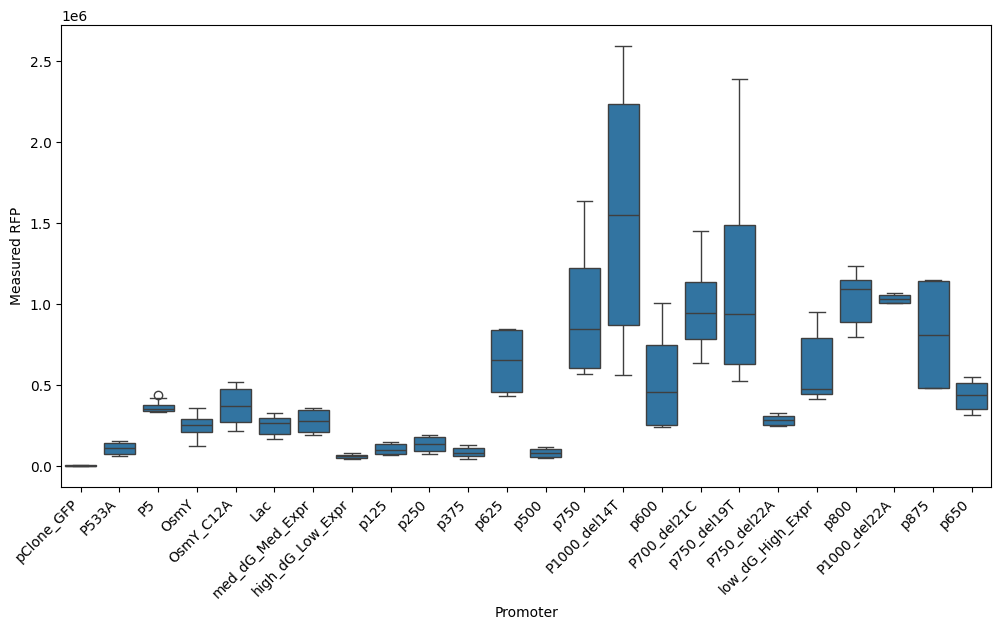

In [82]:
df_cut.loc[:, 'Ec'] = df_cut['Ec'].astype(str)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(str)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='Description', y='Ex550Em650')
plt.xlabel('Promoter')
plt.ylabel('Measured RFP')

plt.xticks(rotation=45, ha='right')

plt.show()


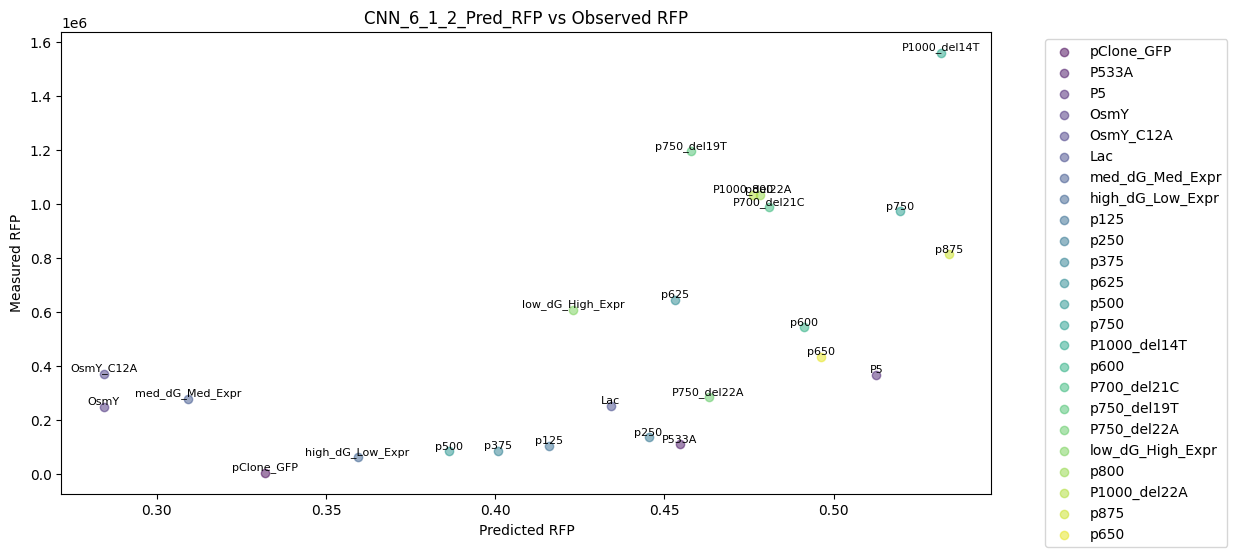

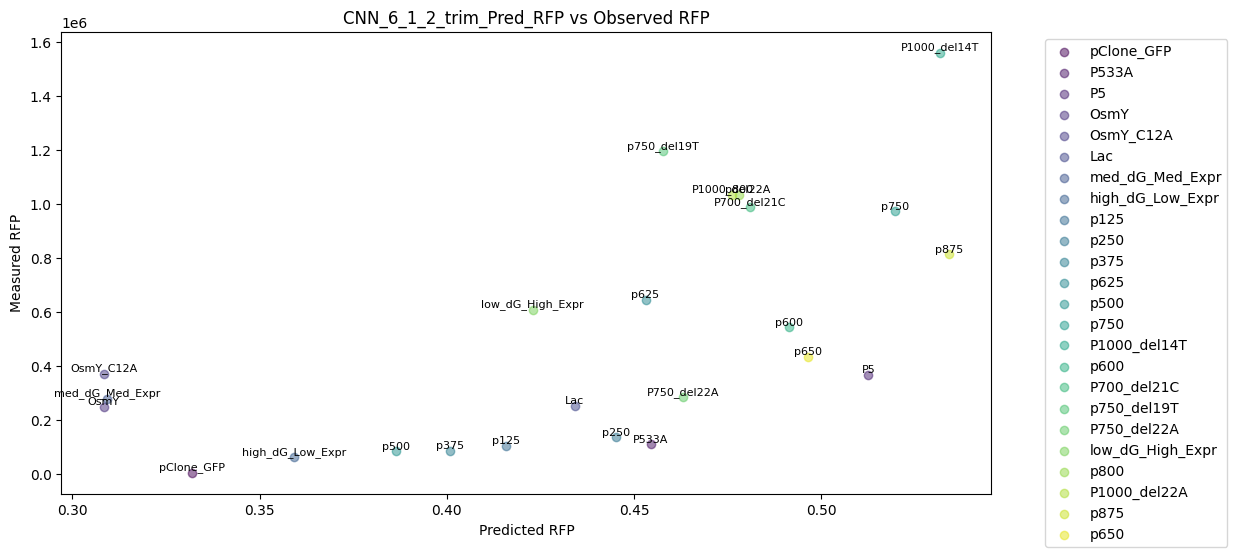

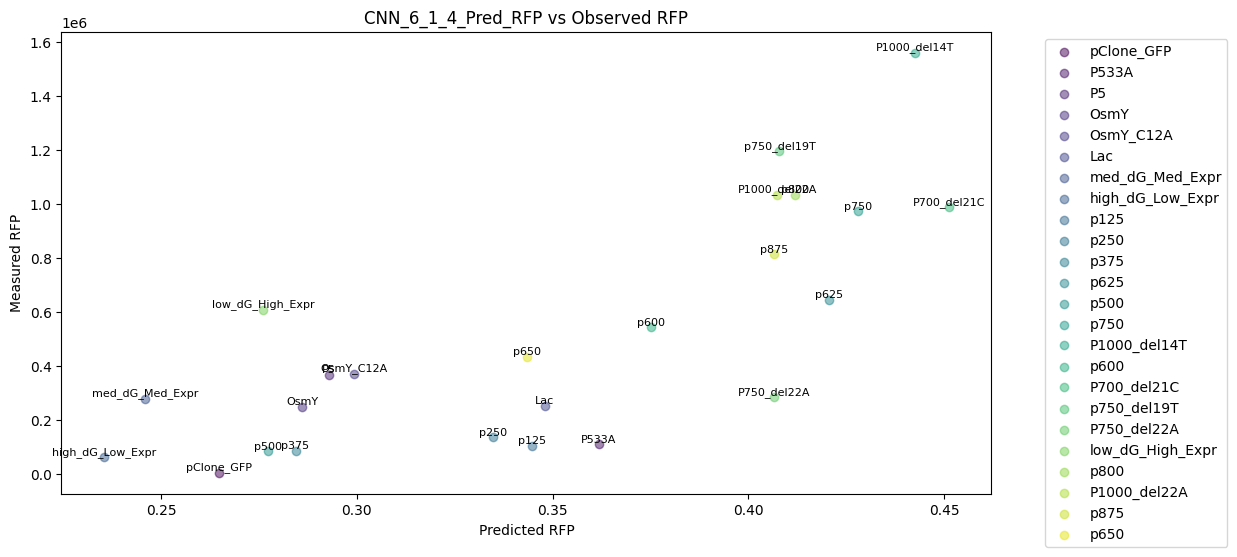

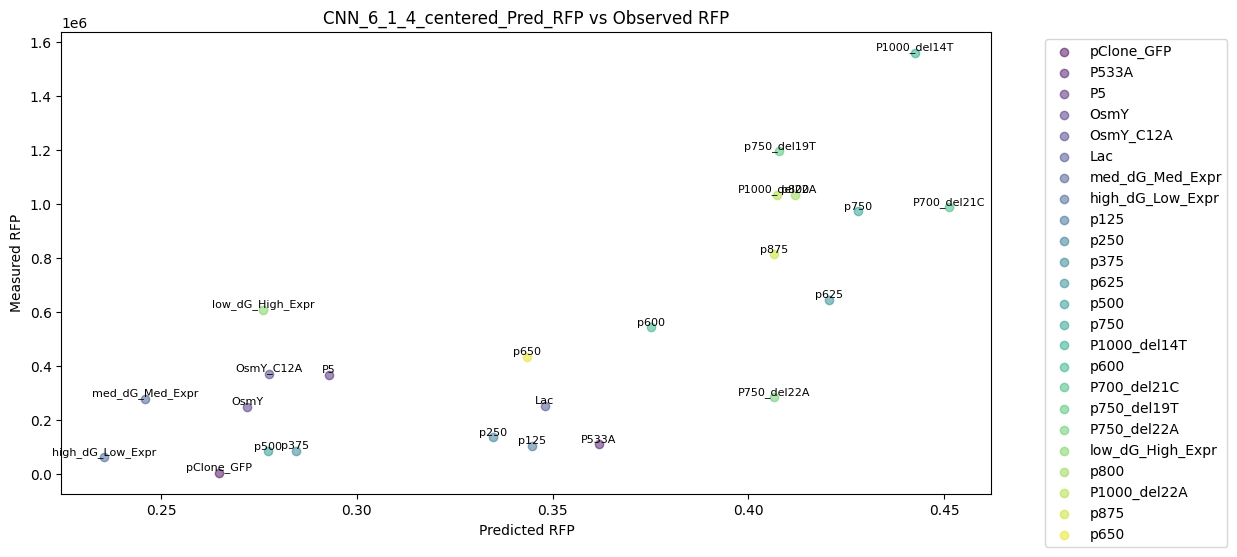

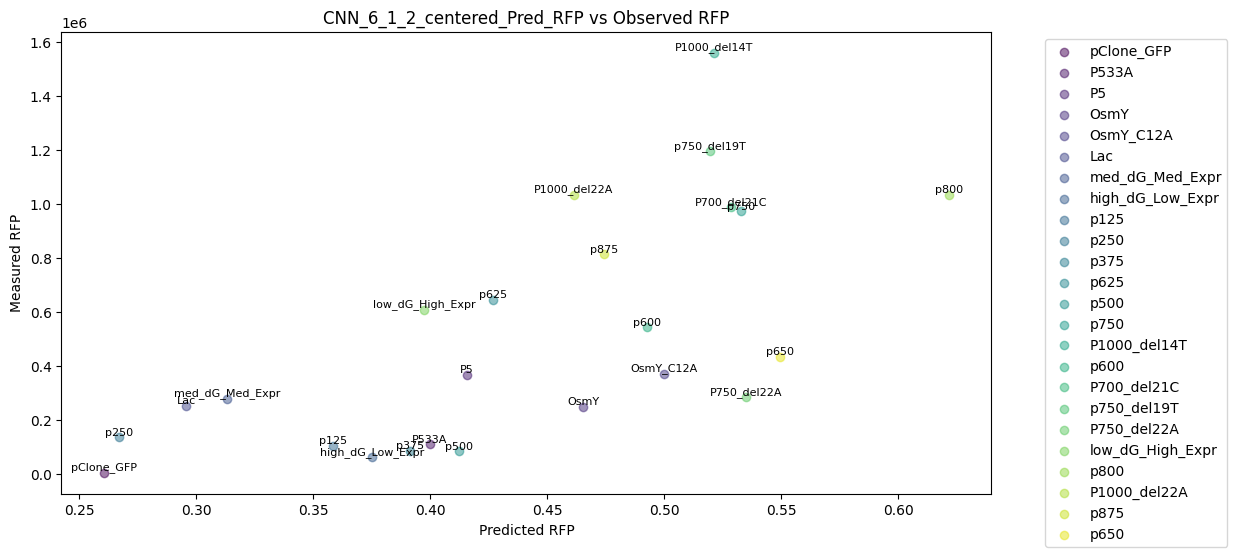

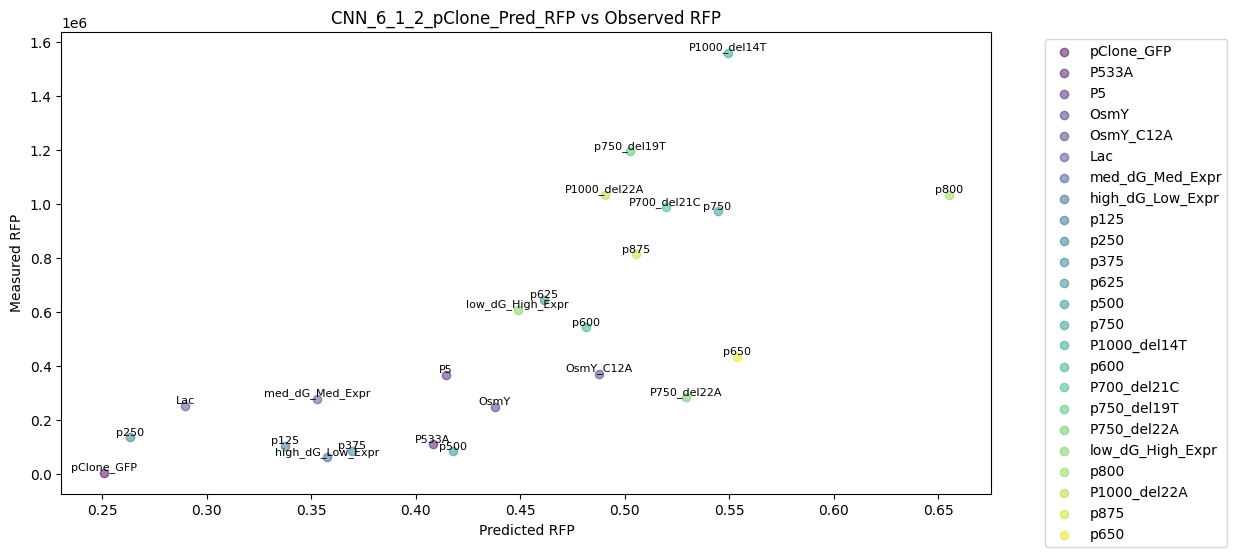

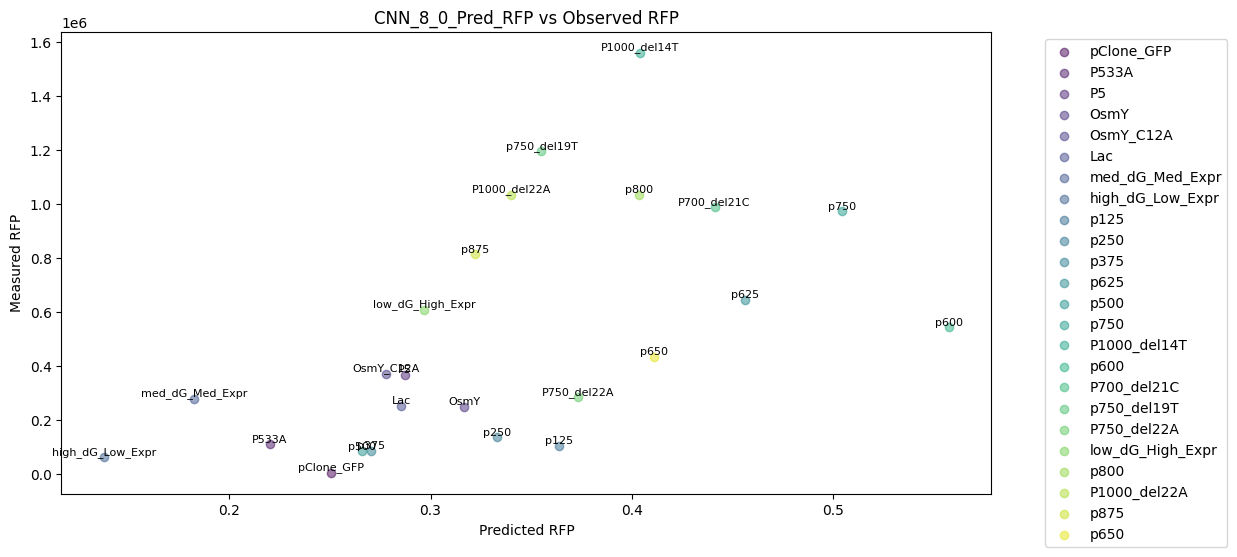

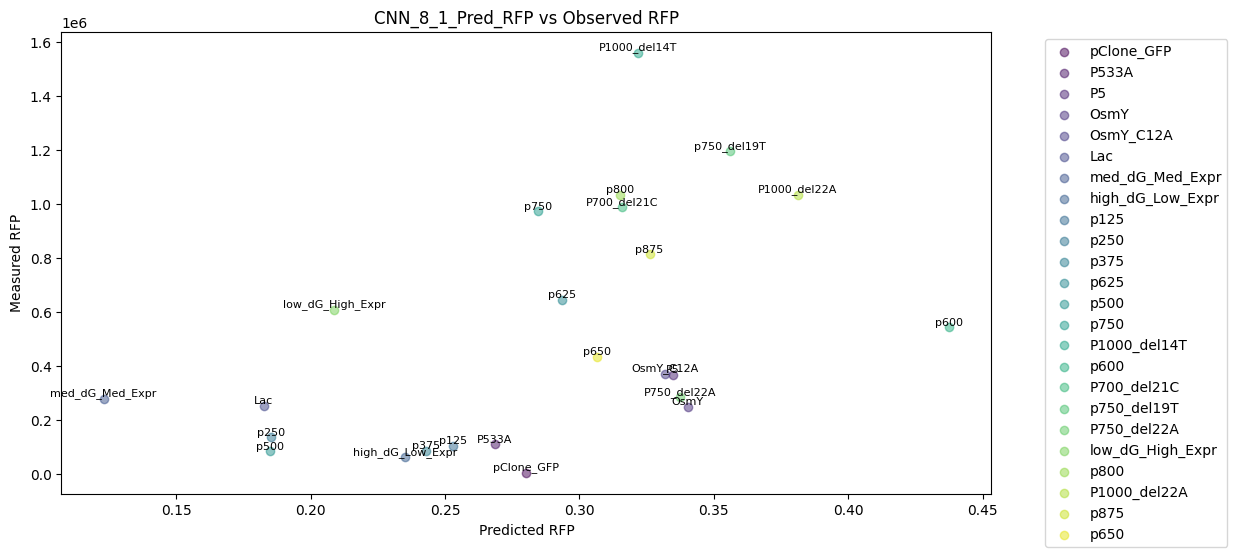

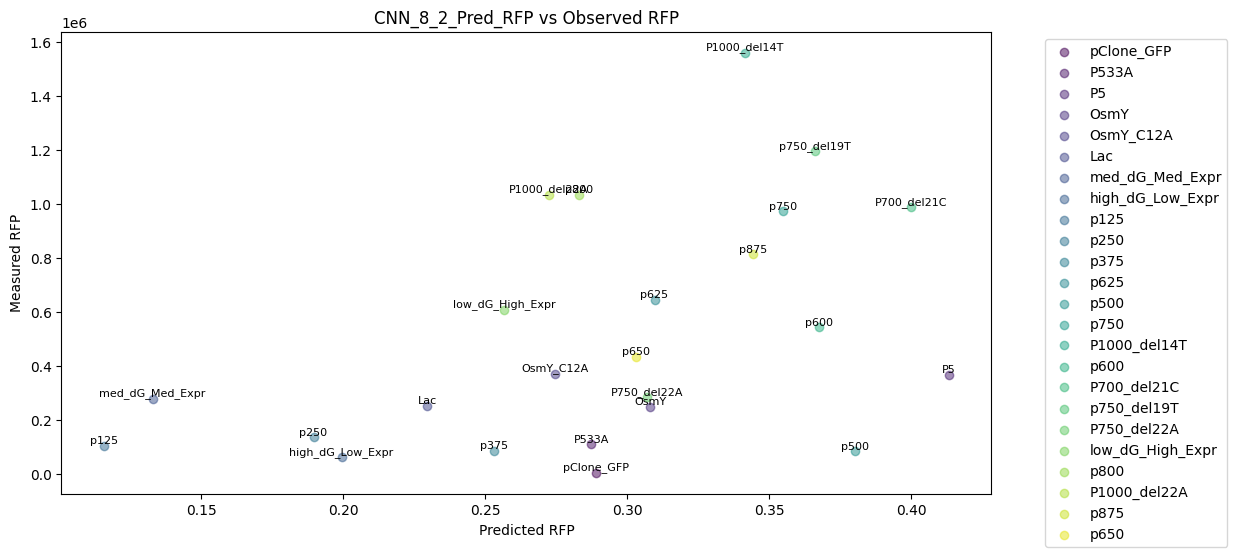

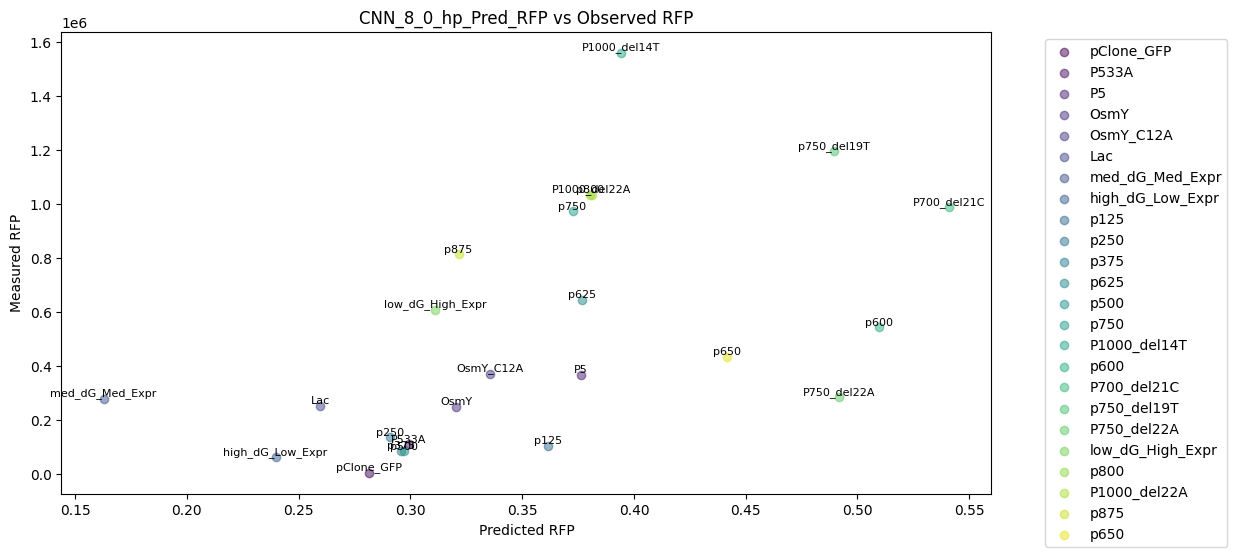

In [83]:
df_cut.loc[:, 'Ec'] = df_cut['Ec'].astype(str)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(str)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

cmap = plt.get_cmap('viridis')
color_map = {desc: cmap(i/len(merged_df['Description'].unique())) for i, desc in enumerate(merged_df['Description'].unique())}

for col in prediction_cols:
    plt.figure(figsize=(12, 6))

    for idx, row in merged_df.iterrows():
        Rel_RFP = row['Ex550Em650']
        Pred_RFP = row[col]
        promoter = row['Description']
        color = color_map[promoter]

        plt.scatter(Pred_RFP, Rel_RFP, color=color, label=promoter, alpha=0.5)
        plt.text(Pred_RFP, Rel_RFP, promoter, fontsize=8, ha='center', va='bottom')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Predicted RFP')
    plt.ylabel('Measured RFP')
    plt.title(f'{col} vs Observed RFP')
    plt.show()


### CNN_8_0 Saliency
---

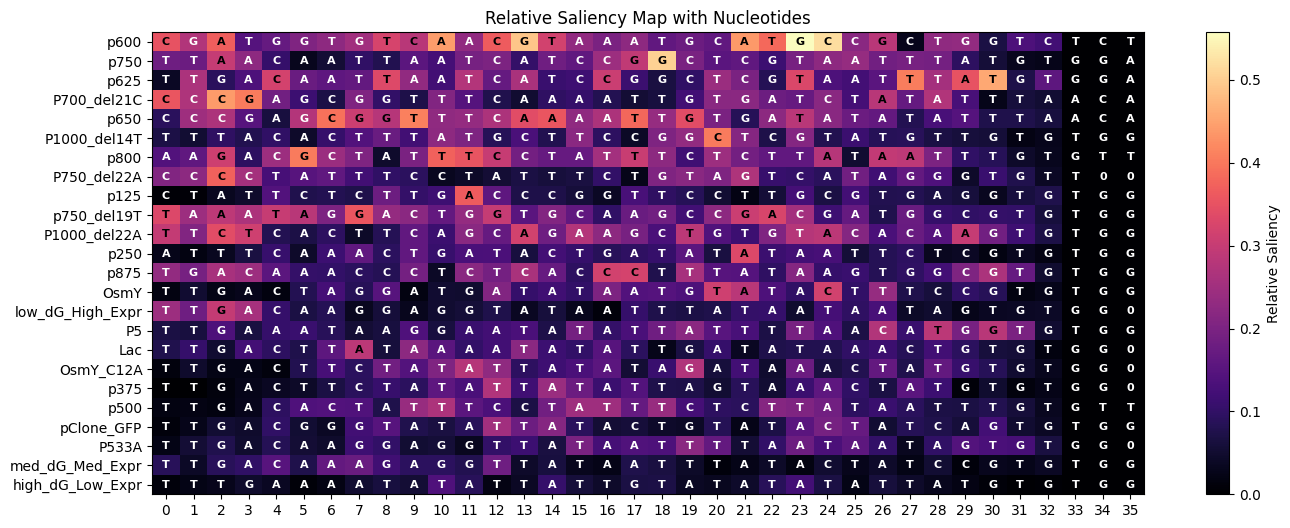

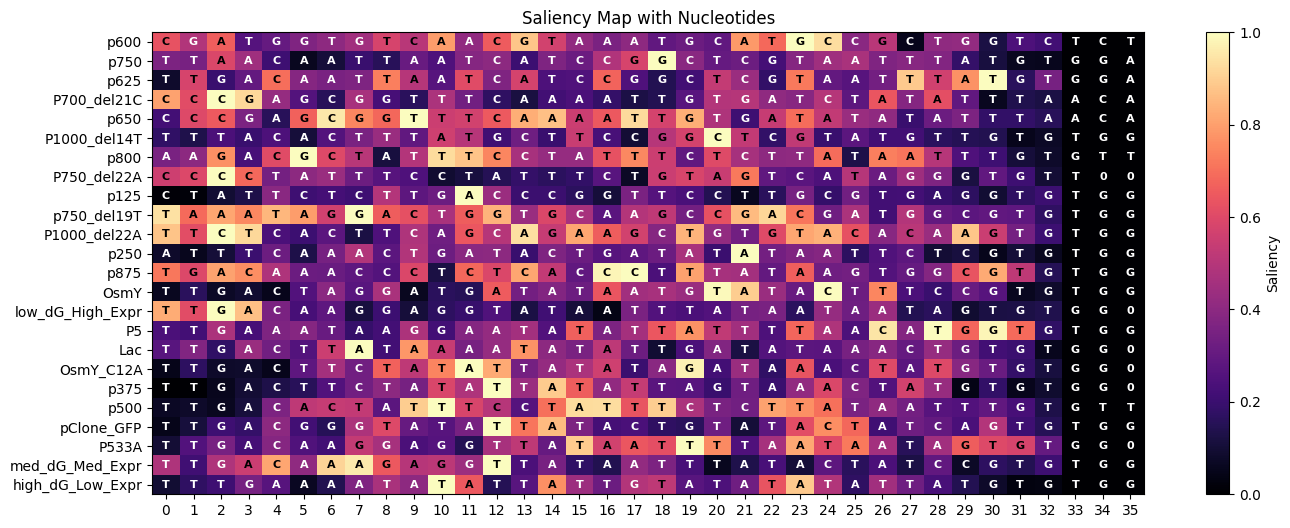

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    sequence = sequence.replace('_', '')
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

model_filename='Models/CNN_8_0.keras'
model = load_model(model_filename)

df_cut.loc[:, 'Ec'] = df_cut['Ec'].astype(str)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(str)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

sequences = merged_df['sequence_trimmed']
y_subset = merged_df['Ex550Em650']

predictions = []
descriptions = merged_df['Description'].unique()
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    seq_clean = seq.replace('_', '')
    seq_padded = seq_clean.ljust(36, '0')
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))

    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# -------------------- Plot Relative Saliency Maps with Nucleotides --------------------

sequences_cleaned = [seq.replace('_', '').ljust(36, '0') for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

plt.figure(figsize=(16, 6))
plt.imshow(
    relative_saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=relative_saliency_matrix.min(),
    vmax=relative_saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = relative_saliency_matrix[i, j]

        norm_value = (value - relative_saliency_matrix.min()) / (relative_saliency_matrix.max() - relative_saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks(np.arange(len(saliency_matrix[0])))
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Relative Saliency')
plt.title('Relative Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = saliency_matrix[i, j]
        norm_value = (value - saliency_matrix.min()) / (saliency_matrix.max() - saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks(np.arange(len(saliency_matrix[0])))
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()



### CNN_8_0_hp Saliency
---

c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


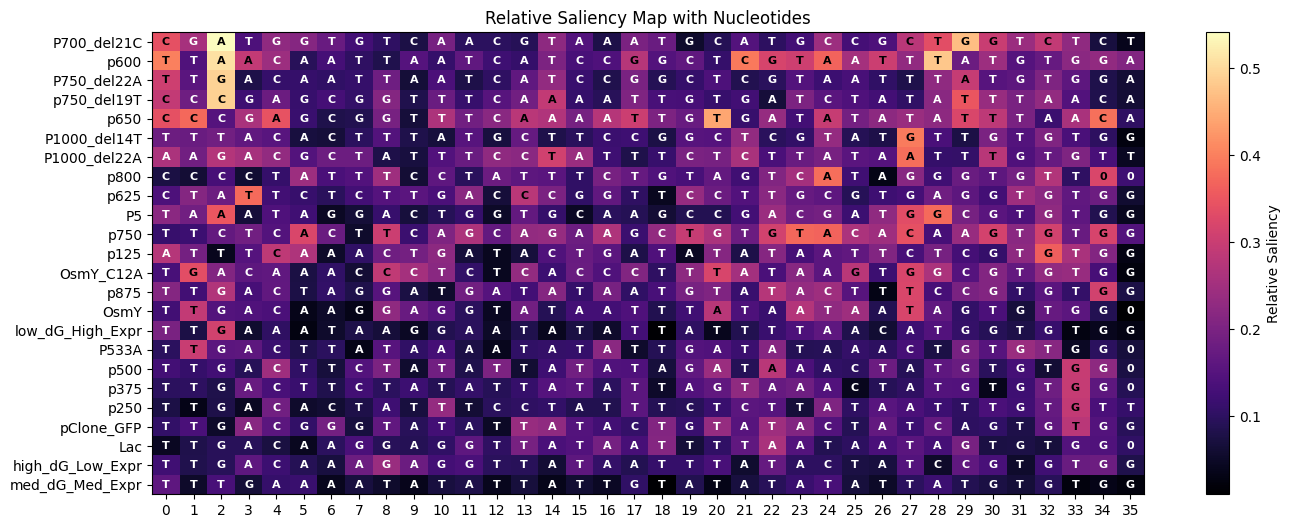

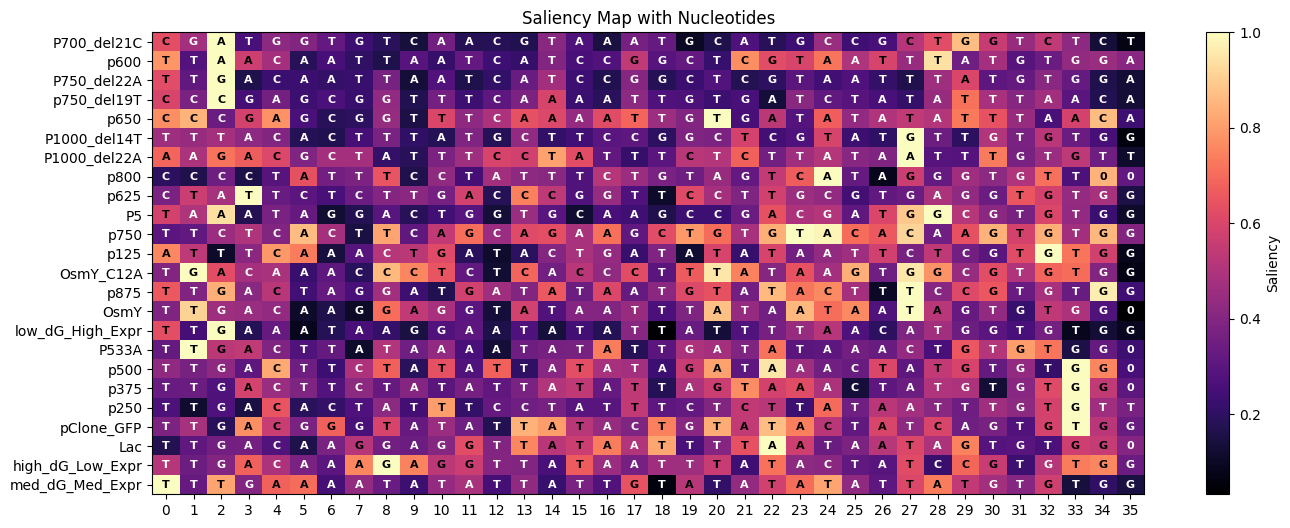

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    sequence = sequence.replace('_', '')
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

model_filename='Models/CNN_8_0_hp.keras'
model = load_model(model_filename)

df_cut.loc[:, 'Ec'] = df_cut['Ec'].astype(str)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(str)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

sequences = merged_df['sequence_trimmed']
y_subset = merged_df['Ex550Em650']

predictions = []
descriptions = merged_df['Description'].unique()
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    seq_clean = seq.replace('_', '')
    seq_padded = seq_clean.ljust(36, '0')
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))

    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# -------------------- Plot Relative Saliency Maps with Nucleotides --------------------

sequences_cleaned = [seq.replace('_', '').ljust(36, '0') for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

plt.figure(figsize=(16, 6))
plt.imshow(
    relative_saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=relative_saliency_matrix.min(),
    vmax=relative_saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = relative_saliency_matrix[i, j]

        norm_value = (value - relative_saliency_matrix.min()) / (relative_saliency_matrix.max() - relative_saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks(np.arange(len(saliency_matrix[0])))
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Relative Saliency')
plt.title('Relative Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = saliency_matrix[i, j]
        norm_value = (value - saliency_matrix.min()) / (saliency_matrix.max() - saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks(np.arange(len(saliency_matrix[0])))
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()



### CNN 6_1_2 Saliency
---

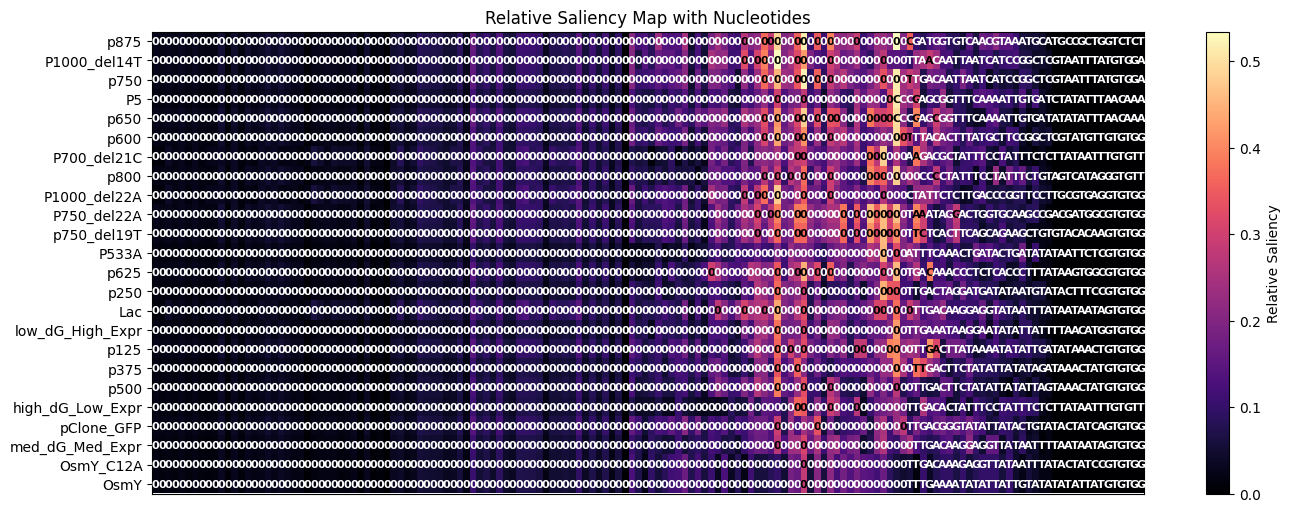

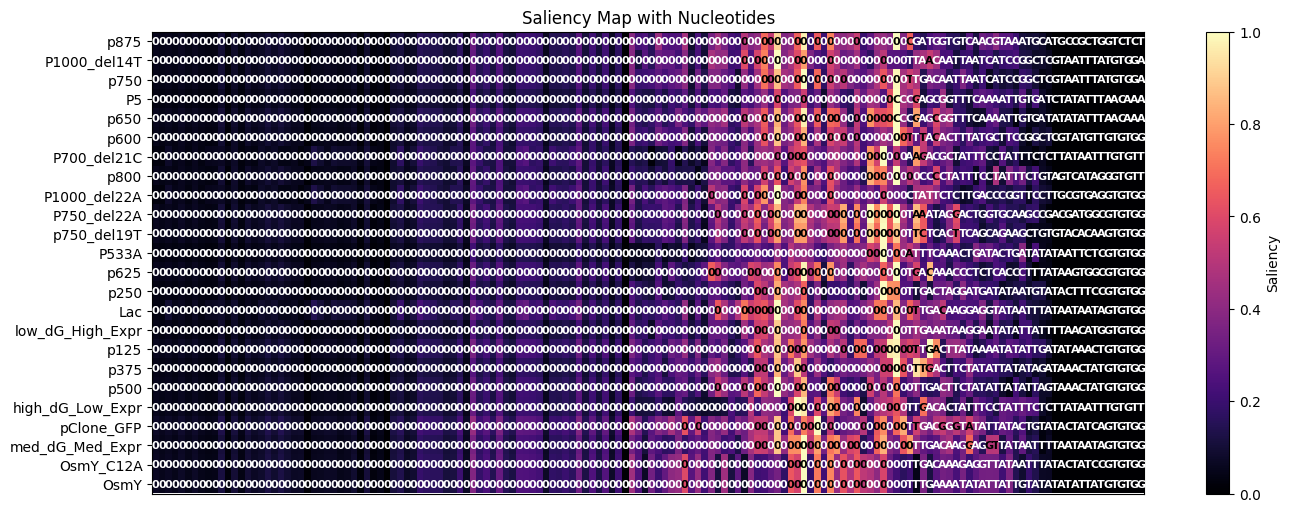

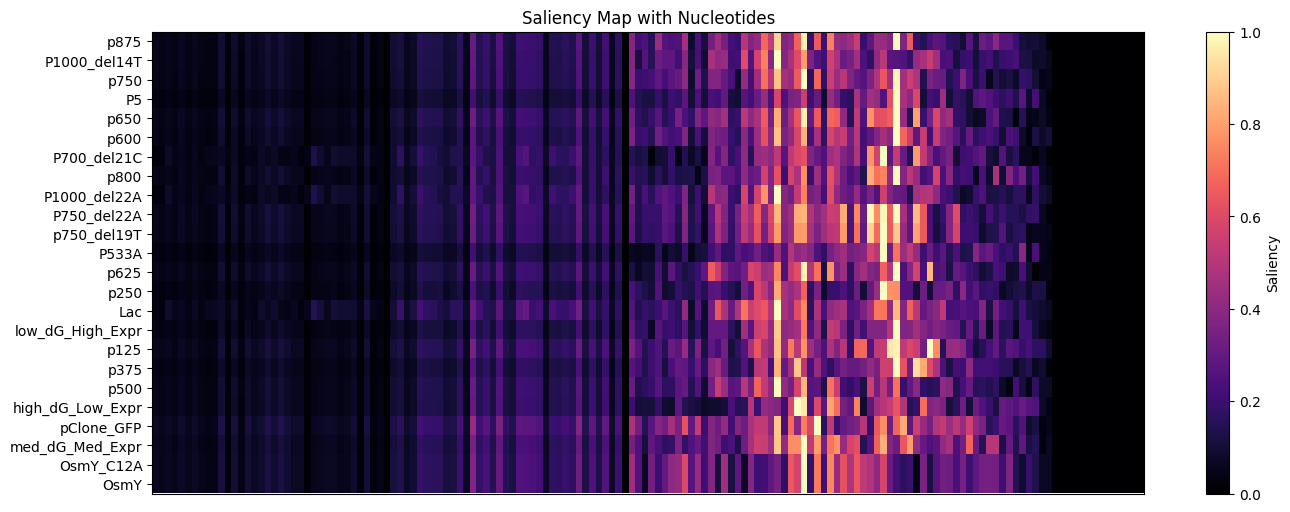

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

def pad_sequence(sequence):
    sequence = sequence.replace('_', '')
    return sequence.zfill(150)

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

model_filename='Models/CNN_6_1_2.keras'
model = load_model(model_filename)

df_cut.loc[:, 'Ec'] = df_cut['Ec'].astype(str)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(str)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

sequences = merged_df['sequence']
y_subset = merged_df['Ex550Em650']

predictions = []
descriptions = merged_df['Description'].unique()
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    seq_padded = pad_sequence(seq)
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))

    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# -------------------- Plot Relative Saliency Maps with Nucleotides --------------------

sequences_cleaned = [pad_sequence(seq) for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

plt.figure(figsize=(16, 6))
plt.imshow(
    relative_saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=relative_saliency_matrix.min(),
    vmax=relative_saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = relative_saliency_matrix[i, j]

        norm_value = (value - relative_saliency_matrix.min()) / (relative_saliency_matrix.max() - relative_saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Relative Saliency')
plt.title('Relative Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = saliency_matrix[i, j]
        norm_value = (value - saliency_matrix.min()) / (saliency_matrix.max() - saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

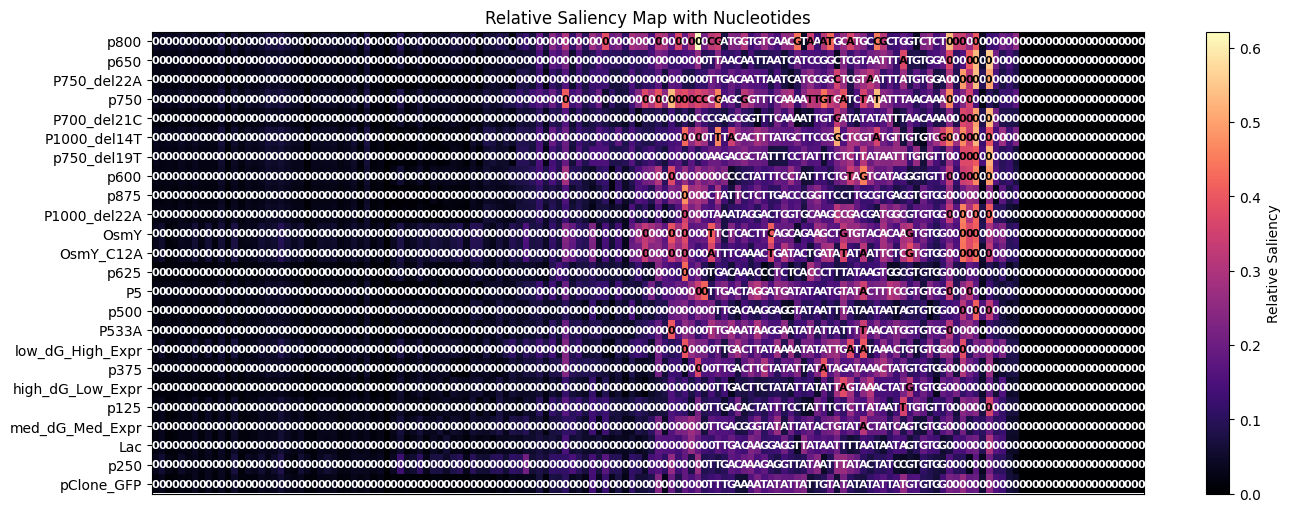

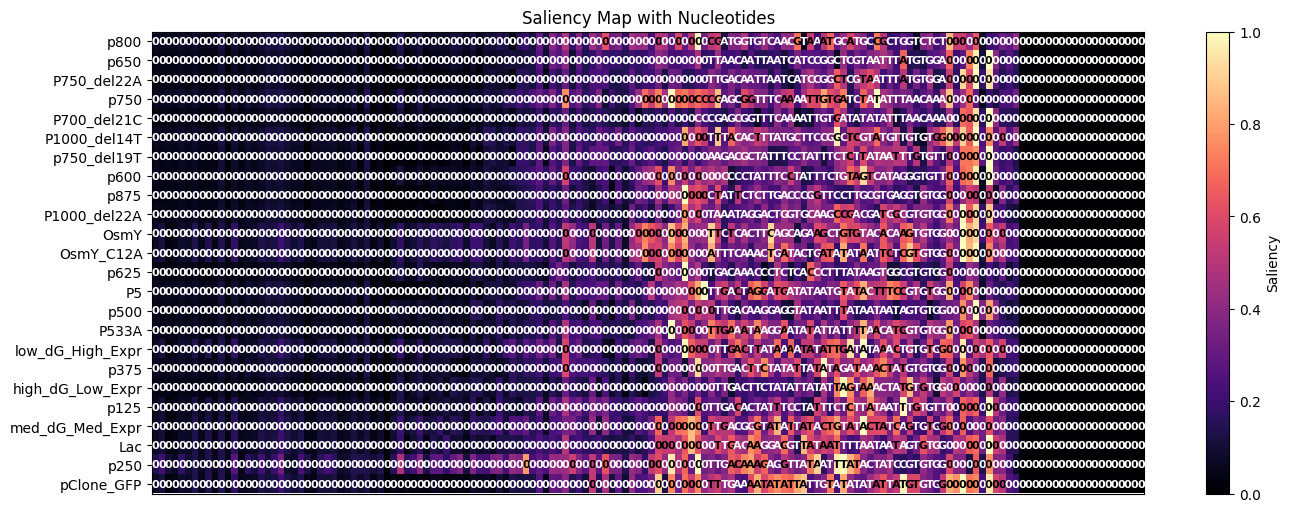

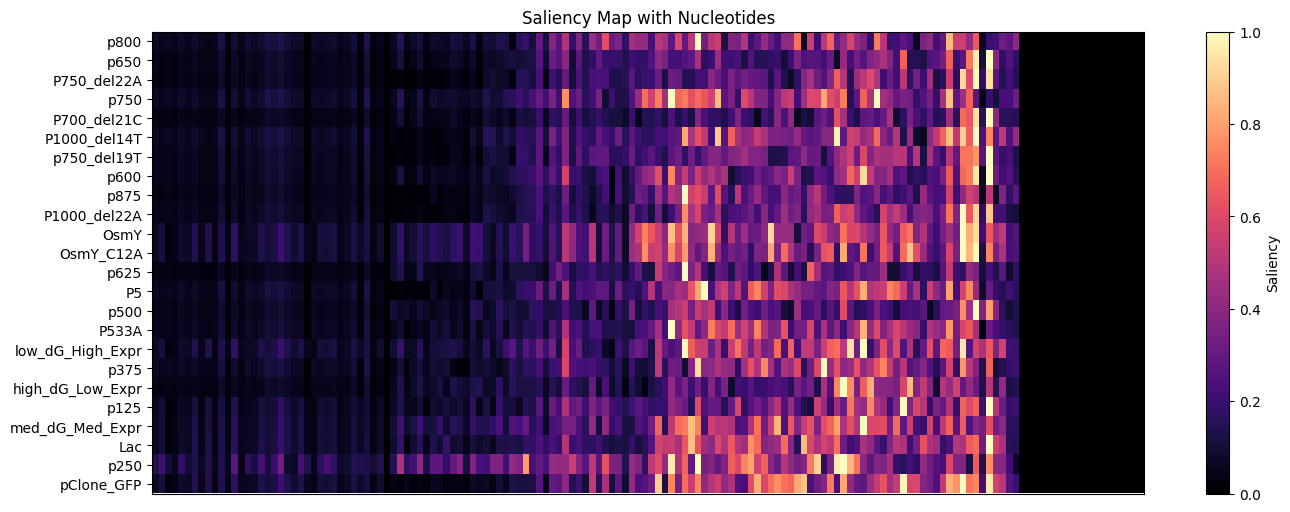

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

def pad_sequence(sequence):
    sequence = sequence.replace('_', '')
    desired_length = 150
    right_padding = 30
    left_padding = desired_length - right_padding - len(sequence)
    return '0' * left_padding + sequence + '0' * right_padding

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

model_filename='Models/CNN_6_1_2.keras'
model = load_model(model_filename)

df_cut.loc[:, 'Ec'] = df_cut['Ec'].astype(str)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(str)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

sequences = merged_df['sequence']
y_subset = merged_df['Ex550Em650']

predictions = []
descriptions = merged_df['Description'].unique()
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    seq_padded = pad_sequence(seq)
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))

    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# -------------------- Plot Relative Saliency Maps with Nucleotides --------------------

sequences_cleaned = [pad_sequence(seq) for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

plt.figure(figsize=(16, 6))
plt.imshow(
    relative_saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=relative_saliency_matrix.min(),
    vmax=relative_saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = relative_saliency_matrix[i, j]

        norm_value = (value - relative_saliency_matrix.min()) / (relative_saliency_matrix.max() - relative_saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Relative Saliency')
plt.title('Relative Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = saliency_matrix[i, j]
        norm_value = (value - saliency_matrix.min()) / (saliency_matrix.max() - saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

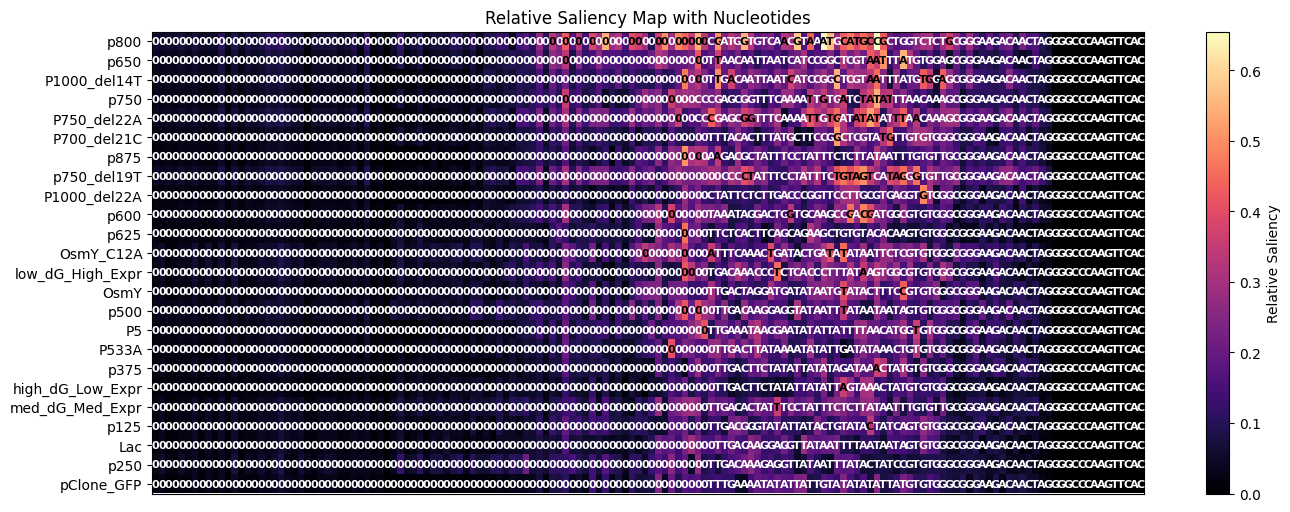

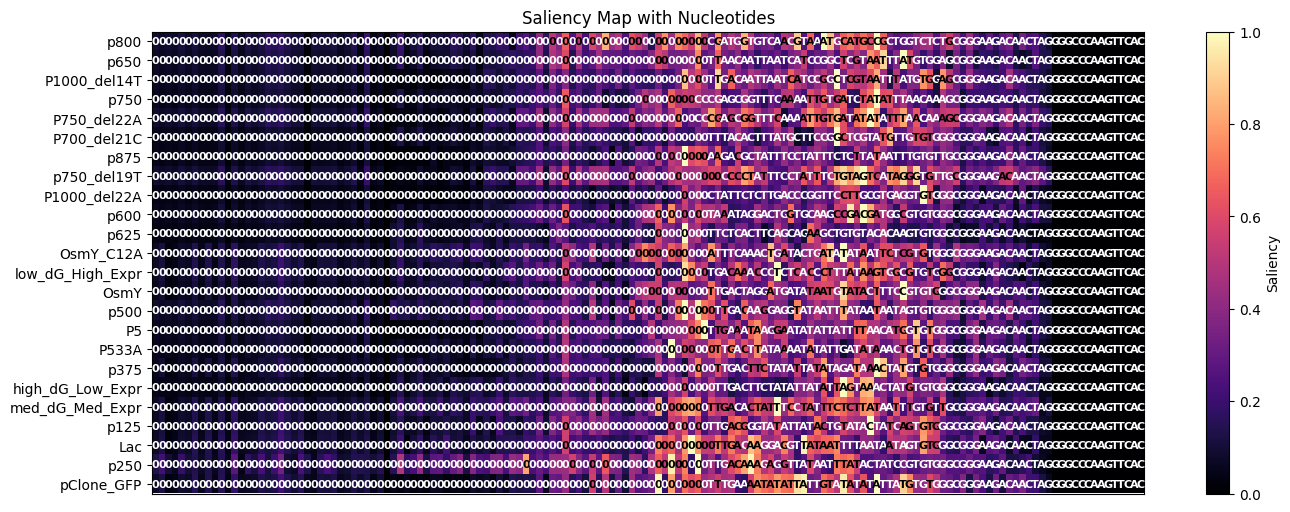

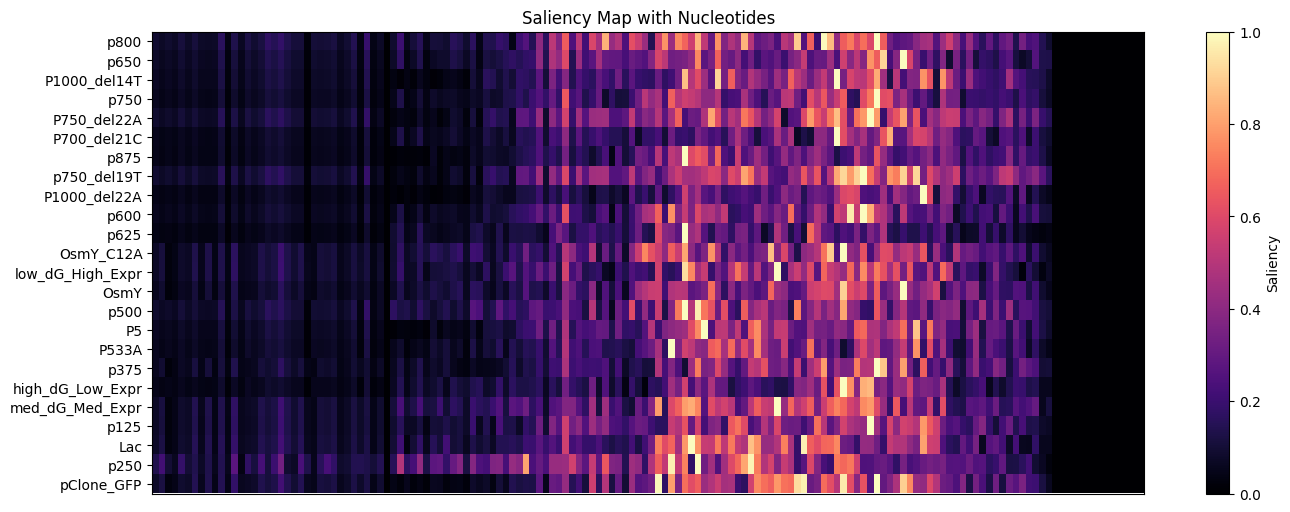

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

def pad_sequence(sequence):
    sequence = sequence.replace('_', '')
    desired_length = 150
    downstream = 'GCGGGAAGACAACTAGGGGCCCAAGTTCAC' # 30bp downstream of the sequence
    left_padding = desired_length - len(downstream) - len(sequence)
    return '0' * left_padding + sequence + downstream


# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

model_filename='Models/CNN_6_1_2.keras'
model = load_model(model_filename)

df_cut.loc[:, 'Ec'] = df_cut['Ec'].astype(str)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(str)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

sequences = merged_df['sequence']
y_subset = merged_df['Ex550Em650']

predictions = []
descriptions = merged_df['Description'].unique()
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    seq_padded = pad_sequence(seq)
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))

    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# -------------------- Plot Relative Saliency Maps with Nucleotides --------------------

sequences_cleaned = [pad_sequence(seq) for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

plt.figure(figsize=(16, 6))
plt.imshow(
    relative_saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=relative_saliency_matrix.min(),
    vmax=relative_saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = relative_saliency_matrix[i, j]

        norm_value = (value - relative_saliency_matrix.min()) / (relative_saliency_matrix.max() - relative_saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Relative Saliency')
plt.title('Relative Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = saliency_matrix[i, j]
        norm_value = (value - saliency_matrix.min()) / (saliency_matrix.max() - saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

### CNN_6_1_4 Saliency

c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


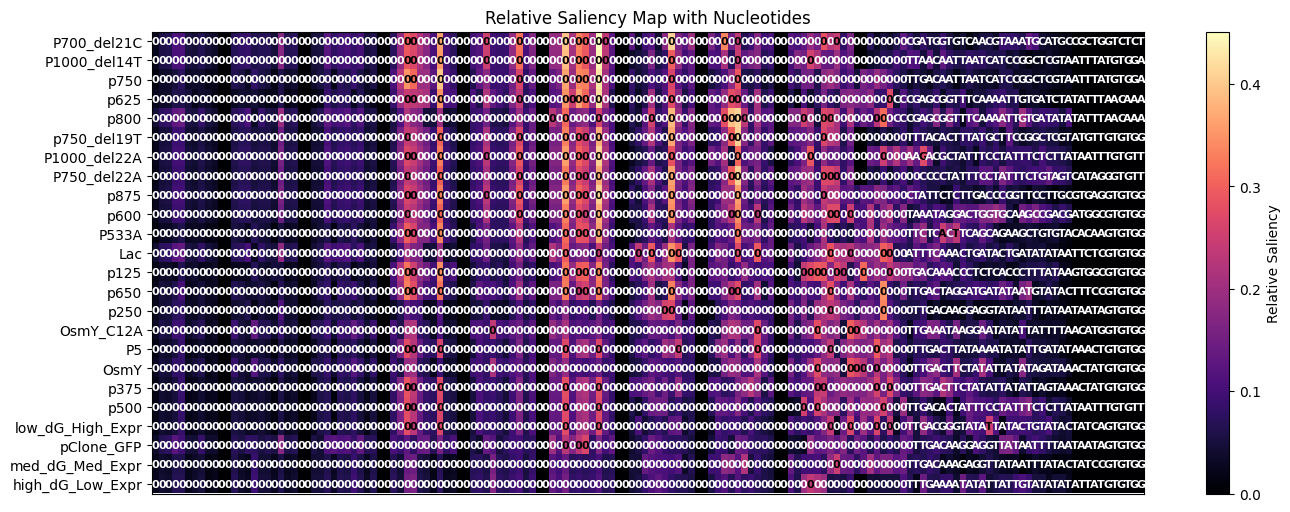

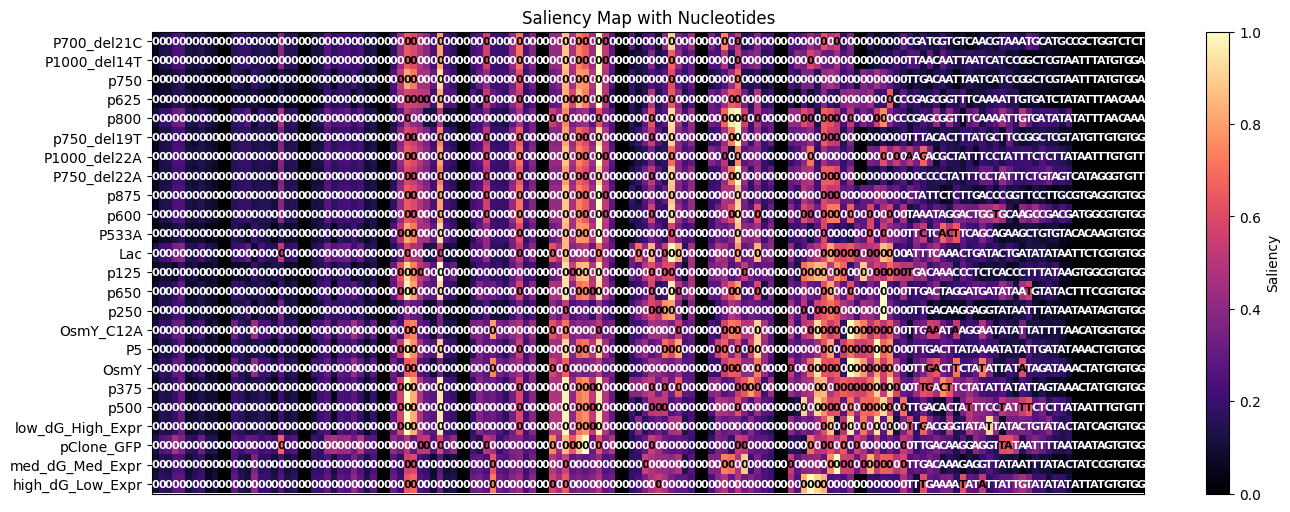

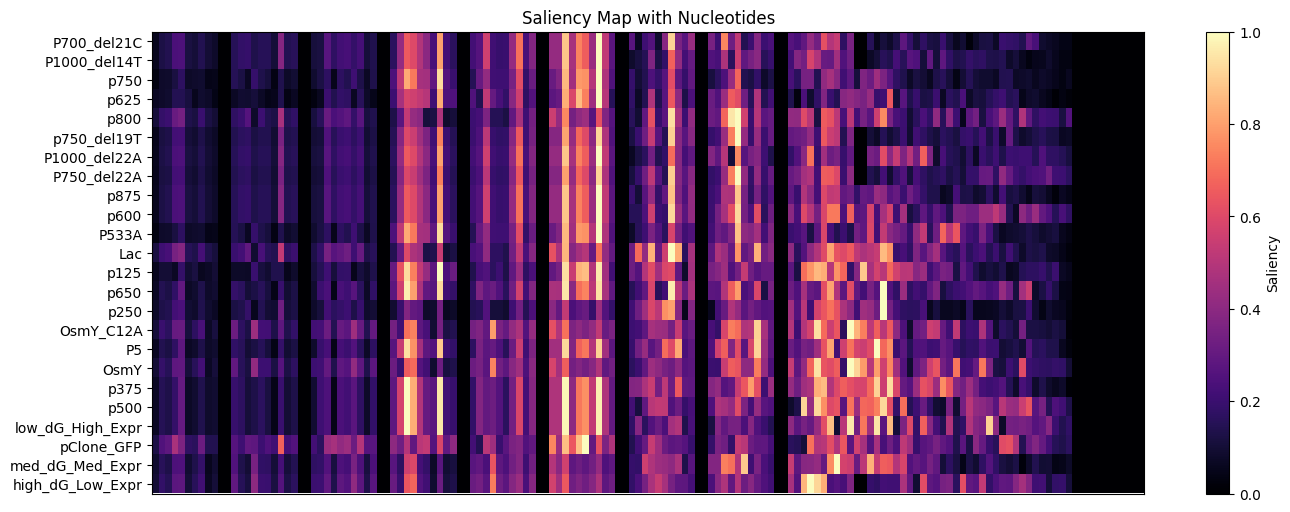

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

def pad_sequence(sequence):
    sequence = sequence.replace('_', '')
    return sequence.zfill(150)

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

model_filename='Models/CNN_6_1_4.keras'
model = load_model(model_filename)

df_cut.loc[:, 'Ec'] = df_cut['Ec'].astype(str)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(str)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

sequences = merged_df['sequence']
y_subset = merged_df['Ex550Em650']

predictions = []
descriptions = merged_df['Description'].unique()
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    seq_padded = pad_sequence(seq)
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))

    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# -------------------- Plot Relative Saliency Maps with Nucleotides --------------------

sequences_cleaned = [pad_sequence(seq) for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

plt.figure(figsize=(16, 6))
plt.imshow(
    relative_saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=relative_saliency_matrix.min(),
    vmax=relative_saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = relative_saliency_matrix[i, j]

        norm_value = (value - relative_saliency_matrix.min()) / (relative_saliency_matrix.max() - relative_saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Relative Saliency')
plt.title('Relative Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = saliency_matrix[i, j]
        norm_value = (value - saliency_matrix.min()) / (saliency_matrix.max() - saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

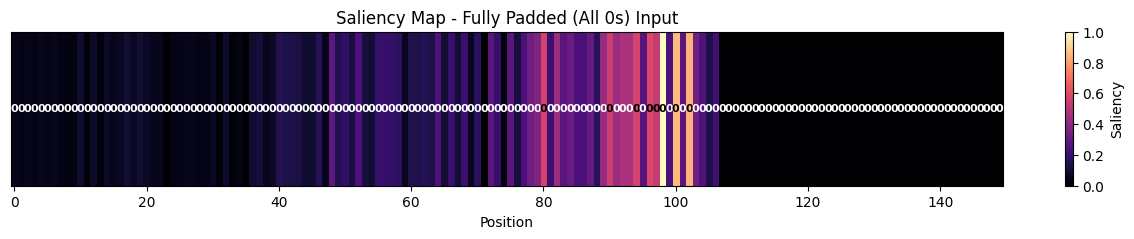

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

# -------------------- Load Your Model --------------------
model_filename = 'Models/CNN_6_1_2.keras'
model = load_model(model_filename)

# -------------------- Encoding Function --------------------
def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    sequence = sequence.replace('_', '')
    encoding = [mapping[nuc.upper()] for nuc in sequence]
    return encoding

# -------------------- Saliency Map Generator --------------------
def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

# -------------------- Plotting Helper --------------------
def plot_saliency_with_text(saliency, sequence, title):
    saliency = np.squeeze(saliency)  # Ensure 1D shape
    plt.figure(figsize=(16, 2))
    plt.imshow(saliency[np.newaxis, :], cmap='magma', aspect='auto')
    plt.title(title)
    plt.colorbar(label='Saliency')
    plt.yticks([])

    min_val, max_val = saliency.min(), saliency.max()
    for j in range(len(sequence)):
        val = saliency[j]
        norm_val = (val - min_val) / (max_val - min_val + 1e-6)
        text_color = 'black' if norm_val > 0.5 else 'white'
        plt.text(j, 0, sequence[j], ha='center', va='center', color=text_color, fontsize=8, fontweight='bold')

    plt.xlabel("Position")
    plt.show()

# -------------------- Generate Inputs and Run Sanity Checks --------------------

# --- Fully padded input (all '0's) ---
padded_sequence = '0' * 150
encoded_padded = np.array(padded_one_hot_encode(padded_sequence), dtype=np.float32)
saliency_padded = generate_saliency_map(model, encoded_padded)
saliency_padded = np.nan_to_num(saliency_padded)
plot_saliency_with_text(saliency_padded, list(padded_sequence), 'Saliency Map - Fully Padded (All 0s) Input')
